In [2]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt

from vgg import VGGNet
from enhanced_vgg import EnhancedVGGNet
from unet import Unet
from fcn8s import FCN8s
from utils import expand_mask, resize, show_single_img, get_prob_map28, dice_loss, actual_predicted
from dataloader import SISSDataset, Rescale, RandomCrop, RandomRotate, ToMultiFloatMaskValues, Normalize

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from torchvision import transforms, models, datasets
import torch.nn.functional as F
# from train import train_model
from unet import Unet
from skimage.transform import resize

In [3]:
siss_dataset = SISSDataset(num_slices=154,
                           num_scans=3,
                           root_dir=Path.cwd().parents[0])

idx = 91
sample = siss_dataset[idx]

def show_single_img(image, label):
    """Show image"""
    cmap = 'gray'
    if label:
        cmap = 'binary'
    plt.imshow(image, cmap = cmap)


def viz_sample(sample):
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle('Sample %d' % idx)

    for slice_, scan in enumerate(['dwi', 'flair', 't1', 't2', 'label']):
        ax = plt.subplot(1, 5, slice_ + 1)
        show_single_img(sample[:, :, slice_], scan == 'label')
        plt.tight_layout()
        ax.set_title(scan)
        ax.axis('off')

    plt.show()

# train dataloader
scale = Rescale(int(1.5 * 230))
crop = RandomCrop(224)
rotate = RandomRotate(20.0)
norm = Normalize()
tupled_float_regress_masks = ToMultiFloatMaskValues()

composed = transforms.Compose([scale,
                               rotate,
                               crop,
                               norm,
                               tupled_float_regress_masks])

composed_for_valset = transforms.Compose([
    Rescale(224),
    norm,
    tupled_float_regress_masks
])


siss = SISSDataset(num_slices = 153,
            num_scans= 2,
            root_dir = Path.cwd().parents[0],
            transform = composed_for_valset        
       )

# train dataset
train_scans = 2
train_dataset = SISSDataset(num_slices = 153,
                            num_scans= train_scans,
                            root_dir = Path.cwd().parents[0],
                            transform = composed)

# val dataset
val_dataset = SISSDataset(num_slices = 153,
                           num_scans= 1,
                           root_dir = Path.cwd().parents[0],
                           transform = composed_for_valset,
                           train = False
                          )

datasets = {
    'train': train_dataset,
    'val': val_dataset
}

# pdb.set_trace()
batch_size = 10
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4)
                for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Image 28 shrinked by bilinear


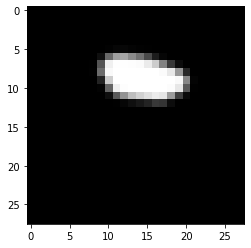

Image 224 shrinked original


Image 224 expanded from shrinked img28


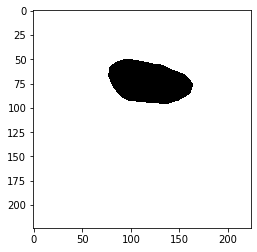

In [4]:
track_sample = siss[91]

scans, label224, label28 = track_sample

from torchvision.ops import RoIAlign
roi_align = RoIAlign((56,56), spatial_scale=1, sampling_ratio=2)

sample_rois= [torch.tensor([[100, 75, 120.0, 80.0]])]

# all are of shape (1, img_size, img_size)
print('Image 28 shrinked by bilinear')
show_single_img(label28[0], label= False)
plt.show()
print('Image 224 shrinked original')
plt.figure(figsize=(224,224))
show_single_img(1-label224[0].numpy(), label = True)
plt.axis('off')
plt.tight_layout()
plt.savefig('mask.png')

plt.show()
print('Image 224 expanded from shrinked img28', )
show_single_img(expand_mask([[0,0,224,224]], label28, (224, 224))[0], label= True)

In [ ]:

roi_align = RoIAlign((56,56), spatial_scale=1, sampling_ratio=2)

sample_rois= [torch.tensor([[100, 75, 120.0, 80.0]])]


roi_aligned112= roi_align(label224, sample_rois)


In [1]:
a = 10

Getting deep at it with experiment 4


In [22]:
sample_rois= [torch.tensor([[50, 25, 150.0, 100.0]])]


In [30]:
label224_with_batch = label224.unsqueeze(0)
label112 = torch.tensor(resize(label224[0], (112, 112))[np.newaxis, np.newaxis, ...], dtype=torch.float32)


In [38]:
from torchvision.ops import RoIAlign
roi_align112 = RoIAlign((28,28), spatial_scale=0.5, sampling_ratio=2)
roi_align224 = RoIAlign((28,28), spatial_scale=1.0, sampling_ratio=2)

roi_aligned112= roi_align112(label112, sample_rois)
roi_aligned224= roi_align224(label224_with_batch, sample_rois)

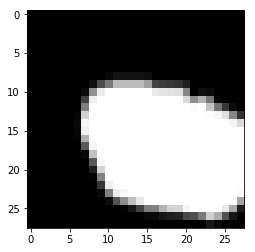

In [39]:
show_single_img(roi_aligned112[0][0], label= False)

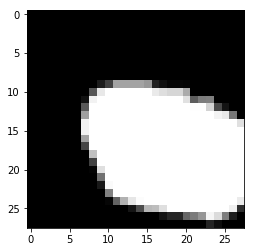

In [42]:
show_single_img(roi_aligned224[0][0], label= False)


VGG model


In [ ]:
vgg_model = VGGNet(freeze_max = False)
net = FCN8s(vgg_model)

enhanced_vgg = EnhancedVGGNet(freeze_max = False)

In [ ]:
x = torch.rand(5, 4, 224, 224)
out = enhanced_vgg(x)

print(out['x1'].shape)
print(out['x2'].shape)
print(out['x3'].shape)
print(out['x4'].shape)
print(out['x5'].shape)


In [ ]:
unet_model = Unet(enhanced_vgg)


In [ ]:
x = torch.rand(5, 4, 224, 224)
out = unet_model(x)

In [ ]:
out.shape

In [ ]:
all_trainable_layers = [param for param in net.parameters() if param.requires_grad ]


_class    = 2
train_scans = 2
batch_size = 5
epochs     = 10
lr         = 1e-6
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
configs    = "FCNs-Cross Entropy Loss _batch{}_epoch{}_RMSprop_scheduler-step{}-gamma{}_lr{}_momentum{}_w_decay{}".format(batch_size, epochs, step_size, gamma, lr, momentum, w_decay)
print("Configs:", configs)

class_weights = torch.tensor([0.1, 0.9])
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(all_trainable_layers, lr=lr, weight_decay=w_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # decay LR by a factor of 0.5 every 30 epochs


Experiment 1: 

a. Get 28x28 predictions

b. Regress the predictions on the 28x28 image by,
     
     i. applying negative LL on the 28x28 softmax prob prediction and the true resampled mask prediction
     ii. dice loss on the rounded values of 28x28 prob prediction and the real mask values. 

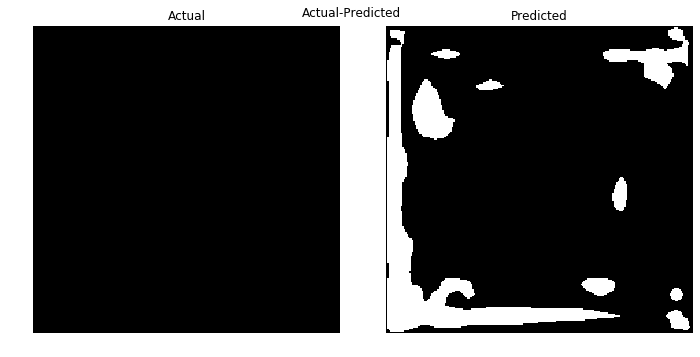

Loss: 542.8260, Dice Loss: 0.9985, Reg Loss: 541.8275


In [7]:
enhanced_vgg = EnhancedVGGNet(freeze_max = False)
exp1 = FCN8s('exp1',enhanced_vgg)
for mini_batch, (inputs, label224, label28) in enumerate(dataloaders['train']):
    
    log_softmax_outputs28 = exp1(inputs)  # shape of pred28 is (batch_size, 2, 28, 28)
    
    softmax_outputs28 = torch.exp(log_softmax_outputs28) 
    output28_prob = get_prob_map28(softmax_outputs28)
    
    expanded_output28_prob = expand_mask([[0,0,224,224]], output28_prob[0].detach().numpy(), (224, 224))
    expanded_label28 = expand_mask([[0,0,224,224]], label28[0].detach().numpy(), (224, 224))

    actual_predicted(expanded_label28[0], expanded_output28_prob[0])
    
    reg_loss = torch.mean(torch.sum(-torch.log(1.0 - torch.abs(output28_prob - label28)), dim=[1,2,3]))
    
    dice_l = dice_loss(input=torch.round(output28_prob), target=torch.round(label28))
    
    total_loss = reg_loss + dice_l
    
    total_loss.backward()
    
    print('Loss: {:.4f}, Dice Loss: {:.4f}, Reg Loss: {:.4f}'.format(total_loss, dice_l, reg_loss))
    
    break

Experiment 2: 

a. Get 28x28 predictions

b. Regress the predictions on the 224x224 image by 

    i. applying negative LL on the 28x28 predictions to preserve the direction
    ii. applying dice loss on the upsampled image to ensure complete spatial coherence 


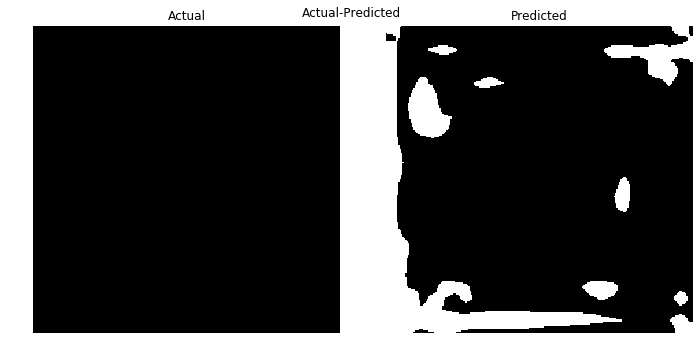

Loss: 0.9073, Dice Loss: 1.0000, Softmax Loss: 0.6911


In [9]:
enhanced_vgg = EnhancedVGGNet(freeze_max = False)
exp2 = FCN8s('exp2',enhanced_vgg)
upsampler = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
for mini_batch, (inputs, label224, label28) in enumerate(dataloaders['train']):
    
    log_softmax_outputs28 = exp2(inputs)  # shape of pred28 is (batch_size, 2, 28, 28)
    
    softmax_loss = F.nll_loss(log_softmax_outputs28, label28.round().squeeze().long(), weight=class_weights)

    softmax_outputs28 = torch.exp(log_softmax_outputs28)
    torch_pred28_prob = get_prob_map28(softmax_outputs28)
    torch_pred224_prob = upsampler(torch_pred28_prob)
    
    rounded_pred224_prob_for_dice = torch.round(torch_pred224_prob)
    # return format is (batch_size, 1, 224, 224)

    dice_l = dice_loss(input=rounded_pred224_prob_for_dice, target=label224)

    actual_predicted(label224[0][0].numpy(), rounded_pred224_prob_for_dice[0][0].detach().numpy())

    # dice_l = dice_loss(input=outputs28, target=mask28)

    total_loss = 0.7* dice_l + 0.3* softmax_loss

    print('Loss: {:.4f}, Dice Loss: {:.4f}, Softmax Loss: {:.4f}'.format(total_loss, dice_l, softmax_loss))
    
    break

Exp 3: Go with full U-net on the other end with a 0.7 dice and 0.3 log-likelihood.

    i. Do upsampling2d + conv for the Upsampling End.
    
Need to improve the versatility of the model with novel connections 

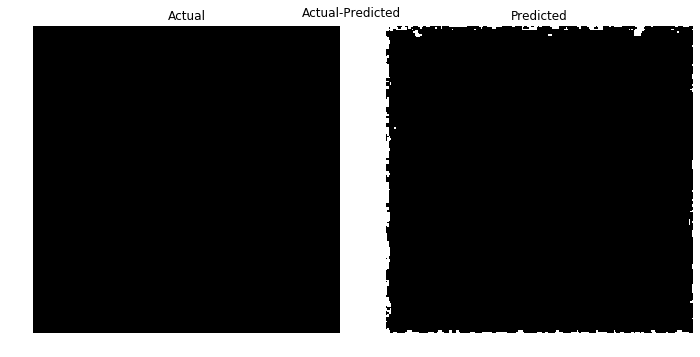

Loss: 0.9368, Dice Loss: 0.9997, Softmax Loss: 0.3709


In [12]:
enhanced_vgg = EnhancedVGGNet(freeze_max = False)
exp3 = FCN8s('exp3', unet_model)
for mini_batch, (inputs, label224, label28) in enumerate(dataloaders['train']):
    
    log_softmax_outputs224 = unet_model(inputs)  # shape of pred224 is (batch_size, 2, 224, 224)
    
    softmax_loss = F.nll_loss(log_softmax_outputs224, label224.squeeze().long(), weight=class_weights)
    
    softmax_outputs224 = torch.exp(log_softmax_outputs224) 
    
    _, pred224_argmax = torch.max(softmax_outputs224, dim=1, keepdim=True)  # (batch_size, 1, 28,28)
    pred224_argmax = pred224_argmax.float()
    
    dice_l = dice_loss(input= pred224_argmax, target=label224)

    actual_predicted(label224[0][0].numpy(), pred224_argmax[0][0].detach().numpy())

    # dice_l = dice_loss(input=outputs28, target=mask28)

    total_loss = 0.9* dice_l + 0.1* softmax_loss

    print('Loss: {:.4f}, Dice Loss: {:.4f}, Softmax Loss: {:.4f}'.format(total_loss, dice_l, softmax_loss))
    
    break

Exp 4: 

For every scan, extract 20 patches, where 10 is of the scan and 10 is without patches. 

Do this by generating randomized bounding boxes around the main scan.

    i. For every set of boxes, extract a common sized (s,s) patch from a specific layer. 
    Mostly the concat layer of size 28x28, with RoI Align
    ii. Apply a patch CNN on top of the feature map from step1.  


Exp 5: 

Do a pyramid RoI align systematically on the experiment from 4 and Time Distributed CNN on multiple layers. 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

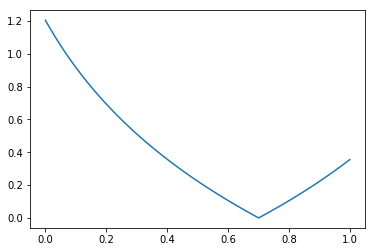

In [12]:
x = np.arange(0,1, 0.001)
y = -np.log(1-np.abs(x-0.7))
plt.plot(x,y)

In [1]:
from enhanced_vgg import StartBlock, IntermediateBlock1, IntermediateBlock2, EnhancedBackbone
import torch
import torch.nn as nn

In [2]:
enh = EnhancedBackbone('clas')

In [3]:
x = torch.rand(5,4,224,224)

In [4]:
batch_size = 5
block1 = StartBlock(batch_size, in_channels=4, out_channels=64, height=224, width=224)    # output is of shape (112, 112, 64) for input of shape (224, 224, 4)
block2 = IntermediateBlock1(batch_size, 64, height=112, width=112)
block3 = IntermediateBlock1(batch_size, 128, height=56, width=56)
block4 = IntermediateBlock2(batch_size, 256, height=28, width= 28)
block5 = IntermediateBlock2(batch_size, 512, height=14, width=14, same_c = True)

In [5]:
out1 = block1(x)

In [8]:
out1['out2'].shape

torch.Size([5, 64, 112, 112])

In [11]:
out2 = block2(out1)

In [16]:
out3 = block3(out2)

In [20]:
out4 = block4(out3)

In [25]:
out5 = block5(out4)

In [26]:
out5['out1'].shape

torch.Size([5, 512, 7, 7])

In [27]:
out5['out2'].shape

torch.Size([5, 512, 7, 7])

In [28]:
out5['out3'].shape

torch.Size([5, 512, 7, 7])